In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# 데이터 확인
data = pd.read_csv('data/ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
# 원본 데이터 별도 확보
data_origin = data

In [4]:
# 각 컬럼별 최대 문장길이
data.astype(str).applymap(len).max()

Q        56
A        76
label     1
dtype: int64

In [5]:
import re

In [6]:
# 특수기호 찾아내는 함수 생성

def find_all_special_chars(df):
    pattern = re.compile(r"[^가-힣a-zA-Z0-9]")
    all_text = " ".join(df.astype(str).values.flatten())
    special_chars = set(pattern.findall(all_text))

    return special_chars

In [7]:
# 사용된 특수기호 목록
special_chars = find_all_special_chars(data)
special_chars

{' ',
 '!',
 '%',
 "'",
 ',',
 '-',
 '.',
 ';',
 '?',
 '_',
 '~',
 '…',
 'ㅊ',
 'ㅋ',
 'ㅎ',
 'ㅜ',
 'ㅠ'}

In [8]:
# 특수기호 포함된 문장 확인 함수

def contains_special_chars(value):
    for char in value:
        if char in (r'%',',', ';', '_', '-', '~', '…', 'ㅊ', 'ㅋ', 'ㅎ', 'ㅜ', 'ㅠ'):
            return True
    return False

def find_special_symbols(df):
    return df[df.astype(str).applymap(contains_special_chars).any(axis=1)]

In [9]:
# 특수기호가 포함된 문장 전체 확인을 위해 csv 파일로 저장
#find_special_symbols(data).to_csv("spc_contain_text.csv")

In [10]:
#7622, 9906번 문장 오타 확인
print(data.iloc[7622])
print(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A         다른 인연이 ㅊ자아올 거예요.
label                    1
Name: 7622, dtype: object
Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두넌 것이에요.-울라프
label                                                2
Name: 9906, dtype: object


In [11]:
# 오타 수정
data.iloc[7622, data.columns.get_loc("A")] = "다른 인연이 찾아올 거예요."
data.iloc[9906, data.columns.get_loc("A")] = "내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프"

In [12]:
# 오타 수정 결과 확인
display(data.iloc[7622])
display(data.iloc[9906])

Q        이별후 8개월이란 시간이 흐르고
A          다른 인연이 찾아올 거예요.
label                    1
Name: 7622, dtype: object

Q                                               사랑의 정의
A        내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두는 것이에요.-울라프
label                                                2
Name: 9906, dtype: object

In [13]:
# 한국어 감정표현을 위해 특수문자는 살리기로 결정
# 반복되는 특수문자('ㅋㅋㅋ', 'ㅎㅎ' 등)는 1개 문자로만 표현
# 특수기호 처리 함수 생성

pattern = r'[!%\',.;?_~…ㅊㅋㅎㅜㅠ-]+'

def clean_text(text):
    return re.sub(pattern, lambda m: f' {m.group(0)[0]} ', text).strip()

In [14]:
# 특수기호 제거 함수 적용
data = data.astype(str).applymap(clean_text)

data

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,PPL 심하네,눈살이 찌푸려지죠 .,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !,2
11819,훔쳐보는 것도 눈치 보임 .,훔쳐보는 거 티나나봐요 .,2
11820,흑기사 해주는 짝남 .,설렜겠어요 .,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요 .,2


In [15]:
data.to_csv('preprocessed_text.csv', index = False)

In [16]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [17]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [18]:
# 멀티헤드어텐션 함수
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [19]:
# 패딩마스크 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [20]:
# 뒤쪽 단어 마스킹을 위한 룩어헤드마스크 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [21]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [22]:
# 패딩마스크 + 임베딩 + 포지셔널인코딩 + 여러겹의 인코딩 레이어
# 인코더 전체 구조 생성
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [24]:
# 패딩마스크 + 임베딩 + 포지셔널인코딩 + 여러겹의 인코딩 레이어
# 인코더 전체 구조 생성
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [25]:
questions = data['Q']
answers = data['A']

In [26]:
questions

0                         12시 땡 !
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         PPL 심하네
                   ...           
11818             훔쳐보는 것도 눈치 보임 .
11819             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [27]:
answers

0                      하루가 또 가네요 .
1                       위로해 드립니다 .
2                     여행은 언제나 좋죠 .
3                     여행은 언제나 좋죠 .
4                      눈살이 찌푸려지죠 .
                   ...            
11818          티가 나니까 눈치가 보이는 거죠 !
11819               훔쳐보는 거 티나나봐요 .
11820                      설렜겠어요 .
11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
11822          도피성 결혼은 하지 않길 바라요 .
Name: A, Length: 11823, dtype: object

In [28]:
import tensorflow_datasets as tfds

In [29]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [30]:
# 단어집합 개수 획인
tokenizer.vocab_size

8361

In [31]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [32]:
# 단어장에 시작토큰와 종료토큰 개수 추가
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8363


In [33]:
# 질문 텍스트에서 토크나이징 후 토큰 개수가 가장 많은 문장을 확인
tokenized_q = [(sentence, len(tokenizer.encode(sentence))) for sentence in questions]

longest_sentence_q, max_tokens_q = max(tokenized_q, key=lambda x: x[1])

print(f"질문 문장에서 토큰 개수가 가장 많은 문장: {longest_sentence_q}")
print(f"토큰 개수: {max_tokens_q}")

질문 문장에서 토큰 개수가 가장 많은 문장: 헤어지고 뜨문뜨문 연락은 다시 시작하긴 뭐하고 남주긴 아까운 뭐 이런마음인건가 ?
토큰 개수: 21


In [34]:
# 응답 텍스트에서 토크나이징 후 토큰 개수가 가장 많은 문장을 확인
tokenized_a = [(sentence, len(tokenizer.encode(sentence))) for sentence in answers]

longest_sentence_a, max_tokens_a = max(tokenized_a, key=lambda x: x[1])

print(f"답변 문장에서 토큰 개수가 가장 많은 문장: {longest_sentence_a}")
print(f"토큰 개수: {max_tokens_a}")

답변 문장에서 토큰 개수가 가장 많은 문장: 연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지는 과정인데 ,  그 과정을 못 참고 피하기만 했나봅니다 .
토큰 개수: 29


In [35]:
# 토큰 개수가 가장 많은 문장의 토큰 개수인 max_tokens_a을 최대 길이로 사용
# 패딩 수행

MAX_LENGTH = max_tokens_a + 2

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):

    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [36]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [37]:
#교사강요
#데이터를 tf.data.Dataset객체로 변환
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [49]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model1 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model1.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [50]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model2.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [51]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model3 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model3.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [40]:
# 패딩영역을 제외한 손실함수 계산

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [41]:
# 학습률 커스터마이징
# 4000번의 웜업 이후 학습률을 줄이는 형태로 설정

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [42]:
#모델 컴파일

# 학습률 스케줄 설정
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수 정의
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [53]:
# 모델 컴파일
model1.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model3.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Epoch 1/20
185/185 [==============================] - 14s 47ms/step - loss: 1.3610 - accuracy: 0.0633
Epoch 2/20
185/185 [==============================] - 9s 47ms/step - loss: 1.1432 - accuracy: 0.0746
Epoch 3/20
185/185 [==============================] - 9s 47ms/step - loss: 1.0131 - accuracy: 0.0839
Epoch 4/20
185/185 [==============================] - 9s 47ms/step - loss: 0.8880 - accuracy: 0.0968
Epoch 5/20
185/185 [==============================] - 9s 47ms/step - loss: 0.7706 - accuracy: 0.1098
Epoch 6/20
185/185 [==============================] - 9s 47ms/step - loss: 0.6589 - accuracy: 0.1228
Epoch 7/20
185/185 [==============================] - 9s 47ms/step - loss: 0.5557 - accuracy: 0.1358
Epoch 8/20
185/185 [==============================] - 9s 47ms/step - loss: 0.4619 - accuracy: 0.1487
Epoch 9/20
185/185 [==============================] - 9s 47ms/step - loss: 0.3750 - accuracy: 0.1616
Epoch 10/20
185/185 [==============================] - 9s 46ms/step - loss: 0.3007 - accur

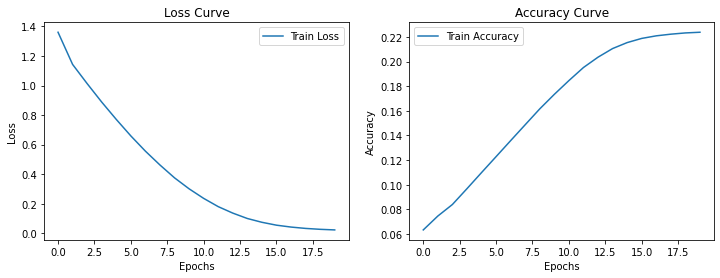

In [55]:
# 학습 수행
EPOCHS = 20
history1 = model1.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history1):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history1)

Epoch 1/40
185/185 [==============================] - 15s 47ms/step - loss: 1.3472 - accuracy: 0.0646
Epoch 2/40
185/185 [==============================] - 9s 47ms/step - loss: 1.1330 - accuracy: 0.0752
Epoch 3/40
185/185 [==============================] - 9s 47ms/step - loss: 0.9858 - accuracy: 0.0866
Epoch 4/40
185/185 [==============================] - 9s 47ms/step - loss: 0.8421 - accuracy: 0.1016
Epoch 5/40
185/185 [==============================] - 9s 47ms/step - loss: 0.7085 - accuracy: 0.1166
Epoch 6/40
185/185 [==============================] - 9s 47ms/step - loss: 0.5832 - accuracy: 0.1316
Epoch 7/40
185/185 [==============================] - 9s 47ms/step - loss: 0.4684 - accuracy: 0.1473
Epoch 8/40
185/185 [==============================] - 9s 47ms/step - loss: 0.3681 - accuracy: 0.1615
Epoch 9/40
185/185 [==============================] - 9s 47ms/step - loss: 0.2832 - accuracy: 0.1747
Epoch 10/40
185/185 [==============================] - 9s 47ms/step - loss: 0.2122 - accur

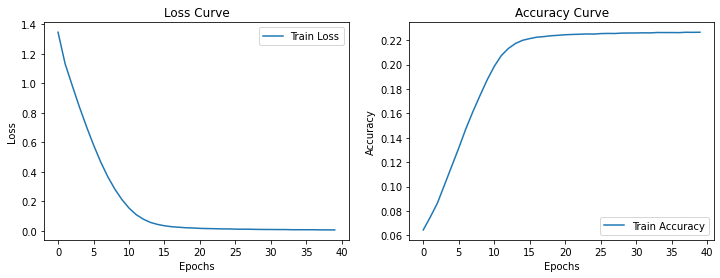

In [54]:
# 학습 수행
EPOCHS = 40
history2 = model2.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history2):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history2.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history2.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history2)

Epoch 1/60
185/185 [==============================] - 15s 47ms/step - loss: 1.3658 - accuracy: 0.0625
Epoch 2/60
185/185 [==============================] - 9s 47ms/step - loss: 1.1404 - accuracy: 0.0747
Epoch 3/60
185/185 [==============================] - 9s 47ms/step - loss: 1.0145 - accuracy: 0.0843
Epoch 4/60
185/185 [==============================] - 9s 47ms/step - loss: 0.8954 - accuracy: 0.0962
Epoch 5/60
185/185 [==============================] - 9s 47ms/step - loss: 0.7837 - accuracy: 0.1085
Epoch 6/60
185/185 [==============================] - 9s 47ms/step - loss: 0.6769 - accuracy: 0.1207
Epoch 7/60
185/185 [==============================] - 9s 47ms/step - loss: 0.5778 - accuracy: 0.1332
Epoch 8/60
185/185 [==============================] - 9s 47ms/step - loss: 0.4853 - accuracy: 0.1457
Epoch 9/60
185/185 [==============================] - 9s 47ms/step - loss: 0.4013 - accuracy: 0.1581
Epoch 10/60
185/185 [==============================] - 9s 47ms/step - loss: 0.3254 - accur

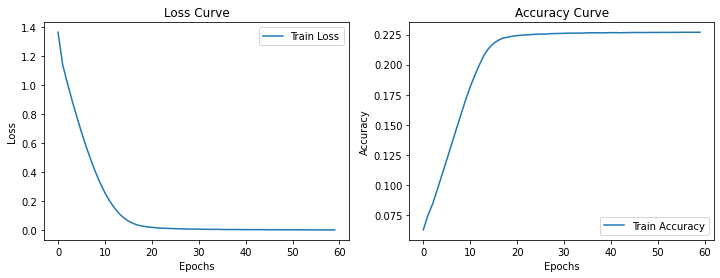

In [56]:
# 학습 수행
EPOCHS = 60
history3 = model3.fit(dataset, epochs=EPOCHS, verbose=1)

# **손실 및 정확도 그래프 출력**
def plot_learning_curves(history3):
    plt.figure(figsize=(12, 4))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history3.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history3.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

# 그래프 출력
plot_learning_curves(history3)

In [77]:
# 새로운 decoder_inference 함수 (모델을 매개변수로 받도록 수정)
def decoder_inference(sentence, model):
    sentence = clean_text(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [81]:
def sentence_generation_multi_models(sentence, models):
    for model in models:
        prediction = decoder_inference(sentence, model)

        predicted_sentence = tokenizer.decode(
            [i for i in prediction if i < tokenizer.vocab_size]
        )

        # 특정 특수문자 앞 공백 제거
        predicted_sentence = re.sub(r'\s*([!%\',.;?_~…ㅊㅋㅎㅜㅠ-])', r'\1', predicted_sentence)

        print('입력 : {}'.format(sentence))
        print('출력 : {}\n'.format(predicted_sentence))

In [82]:
# model1 -> 학습횟수 20
# model2 -> 학습횟수 40
# model3 -> 학습횟수 60
models = [model1, model2, model3]

In [83]:
# 테스트1
sentence_generation_multi_models('나랑 같이 밥 먹을래?', models)

입력 : 나랑 같이 밥 먹을래?
출력 : 같이 놀아요.

입력 : 나랑 같이 밥 먹을래?
출력 : 저는 배터리가 밥이예요.

입력 : 나랑 같이 밥 먹을래?
출력 : 옳소.



In [84]:
# 테스트2
sentence_generation_multi_models('내가 약속이 있어서 그런데 우리 약속은 내일로 미룰까?', models)

입력 : 내가 약속이 있어서 그런데 우리 약속은 내일로 미룰까?
출력 : 이럴 때 잘 쉬는 게 중요해요.

입력 : 내가 약속이 있어서 그런데 우리 약속은 내일로 미룰까?
출력 : 두근거리겠어요.

입력 : 내가 약속이 있어서 그런데 우리 약속은 내일로 미룰까?
출력 : 두근거리겠어요.



In [85]:
# 테스트3
sentence_generation_multi_models('내 여자친구는 나를 안좋아하는거 같아 ㅠㅜ', models)

입력 : 내 여자친구는 나를 안좋아하는거 같아 ㅠㅜ
출력 : 이제 그리워하지마세요.

입력 : 내 여자친구는 나를 안좋아하는거 같아 ㅠㅜ
출력 : 눈을 감고 마음을 가라앉혀봐요.

입력 : 내 여자친구는 나를 안좋아하는거 같아 ㅠㅜ
출력 : 이제 먼저 선톡을 해보세요.



In [87]:
# 테스트4
sentence_generation_multi_models('내가 좋아하는 사람이 있는데 먼저 연락해도 될까?', models)

입력 : 내가 좋아하는 사람이 있는데 먼저 연락해도 될까?
출력 : 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.

입력 : 내가 좋아하는 사람이 있는데 먼저 연락해도 될까?
출력 : 그럼요.  연락해보세요.

입력 : 내가 좋아하는 사람이 있는데 먼저 연락해도 될까?
출력 : 사랑에 관심 있는 사람들이 많죠.



### 결론

#### - 학습횟수가 가장 많은 모델(60회)보다 중간 횟수 모델(40회)가 더 자연스러운 응답을 보임
#### - 자연어 생성 모델에서 모델 정확도가 어떤 역할을 할지 의문(학습 데이터셋을 따라가는 경향성?)